In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
from visualize import draw_dot
import requests
from nn import Embedding
from nn import Linear, Model
from optimize import Adam

/Users/noahs/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
l1 = Embedding(8, 3)
l2 = Linear(12, 4, activation='Relu')
l3 = Linear(4, 1)
batch_size=12

model = Model([l1, l2, l3])
optim = Adam(model)

In [59]:
X = np.random.uniform(0, 10000000, 1000)
Y = 2*X**2

X_norm = (X - np.mean(X)) / np.std(X)
Y_norm = (Y - np.mean(Y)) / np.std(Y)

In [60]:
for _ in (t:=trange(1000)):
    ix = np.random.randint(0, X_norm.shape[0], (batch_size,)).flatten()

    out = model(X_norm[ix])
    
    optim.zero_grad()

    if (batch_size > 1):
        batch_loss = sum([((val-Y_norm[ix][i])**2)/batch_size for i, val in enumerate(out)])
        batch_loss.backward()
    
    else:
        
        loss = (out-Y_norm[ix][0])**2
        loss.backward()

    optim.step()

    t.set_description(f'loss: {batch_loss.data}')

  0%|          | 0/1000 [00:00<?, ?it/s]

loss: 0.004336101975343615: 100%|██████████| 1000/1000 [00:07<00:00, 126.57it/s]


In [7]:
avg_loss = 0
count = 0
for x, y in zip(X_norm, Y_norm):
    out = model([x])
    loss = (out - y) ** 2
    avg_loss += loss.data
    count += 1
print(f'avg_loss: {avg_loss/count}')

avg_loss: 0.01267174735527684


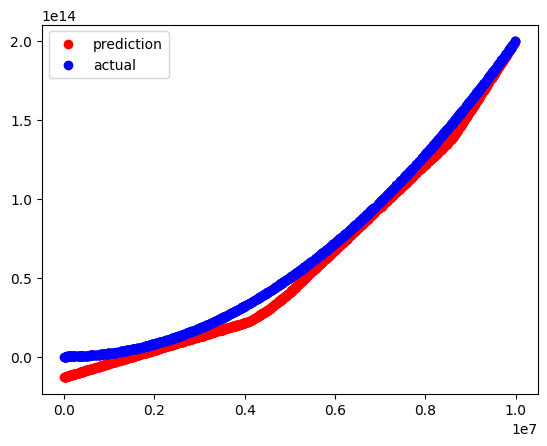

In [8]:
plt.scatter(X, np.array([model([x]).data for x in X_norm]) * np.std(Y) + np.mean(Y), c='r', label='prediction')
plt.scatter(X, Y, c='b', label='actual')
plt.legend()

In [19]:
import numpy as np
import onnx
from onnx import TensorProto
from onnx.helper import make_model, make_node, make_graph, make_tensor_value_info, make_tensor


def build_model(input_dim, output_dim, model, name='model'):
    X = make_tensor_value_info('X', TensorProto.FLOAT, [None, input_dim])
    Y = make_tensor_value_info('Y', TensorProto.FLOAT, [None, output_dim])

    nodes = []
    tensors = []
    
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Embedding):
            print(f'emb: {i}')
            # Flatten the embeddings to a 1D array
            embedding_values = [emb.data for emb in layer.embeddings.flatten()]
            embedding_tensor = make_tensor(f'Embedding{i+1}', TensorProto.FLOAT, [layer.num_embeddings, layer.embedding_dim], embedding_values)
            tensors.append(embedding_tensor)

            X_name = 'X' if i == 0 else f'X{i}'
            Y_name = f'X{i+1}'
            Y_gather_name = f'Gather{Y_name}'

            print(f'X_name: {X_name}')
            print(f'Y_name: {Y_name}')

            # Use Gather operation for embedding lookup
            nodes.append(make_node('Gather', [f'Embedding{i+1}', X_name], [Y_gather_name]))

            nodes.append(make_node('Flatten', [Y_gather_name], [Y_name]))

        else:
            print(f'lin: {i}')
            W_values = np.array([[0.] * len(layer.neurons) for _ in range(len(layer.neurons[0].w))], dtype=np.float32)
            for j in range(len(layer.neurons[0].w)):
                for k in range(len(layer.neurons)):
                        W_values[j][k] = (layer.neurons[k].w[j].data)

            B_values = np.array([])
            for n in layer.neurons:
                B_values = np.append(B_values, n.b.data)

            W = make_tensor(f'W{i+1}', TensorProto.FLOAT, [layer.nin, layer.nout], W_values)
            B = make_tensor(f'B{i+1}', TensorProto.FLOAT, [layer.nout], B_values)

            tensors.extend([W, B])

            X_name = 'X' if i == 0 else f'X{i}'
            Y_name = f'X{i+1}'

            print(f'X_name: {X_name}')
            print(f'Y_name: {Y_name}')

            nodes.append(make_node('MatMul', [X_name, W.name], [f'{X_name}W']))
            nodes.append(make_node('Add', [f'{X_name}W', B.name], [f'{X_name}WB']))
        
            if layer.activation:
                nodes.append(make_node(layer.activation, [f'{X_name}WB'], [Y_name]))

    # Last node output is 'Y'
    nodes[-1].output[0] = 'Y'

    # Assemble the graph and create the model
    graph = make_graph(nodes, name, [X], [Y], tensors)
    onnx_model = make_model(graph, producer_name='onnx-example')

    return onnx_model

In [20]:
onnx_model = build_model(model.input_shape, model.output_shape, model)

onnx.checker.check_model(onnx_model)
onnx.save(onnx_model, 'model.onnx')

emb: 0
X_name: X
Y_name: X1
lin: 1
X_name: X1
Y_name: X2
lin: 2
X_name: X2
Y_name: X3


In [21]:
import onnx2pytorch

pytorch_model = onnx2pytorch.ConvertModel(onnx_model)

/Users/noahs/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
pytorch_model(torch.tensor([[1, 2, 3, 4]]))

tensor([[-0.0001]], grad_fn=<AddmmBackward0>)

In [2]:
names = open('datasets/names.txt', 'r').read().splitlines()
random.shuffle(names)
content_len = 5
feature_count = 15
w_size = 200

chars = sorted(set('.'.join(names)))

itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

def build_dataset(names):
    X, Y = [], []
    context = [0] * content_len
    for name in names:
        name += '.'
        for c in name:
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [3]:
from optimize import Momentum


Xtrain, Ytrain = build_dataset(names)

C = Embedding(27, feature_count)
l1 = Linear(content_len * feature_count, w_size, activation='tanh')
l2 = Linear(w_size, 27)

model = Model([C, l1, l2])

optim = Adam(model=model)
batch_size = 16

In [5]:
from value import Value


for _ in (t:=trange(1)):
    ix = np.random.randint(0, Xtrain.shape[0], (batch_size,))

    out = model(Xtrain[ix])

    if type(out[0]) == Value:
        out = [out]

    expected = Ytrain[ix]

    losses = []

    for i, o in enumerate(out):
        maxVal = max([num.data for num in o])

        exp = [(math.e**(num-maxVal)) for num in o]

        count = sum([num for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(Ytrain[ix][i])].log()*-1

        losses.append(loss)
    
    batch_loss = sum(losses)/batch_size

    optim.zero_grad()

    batch_loss.backward()

    optim.step()
    
    t.set_description(f'loss: {batch_loss.data}')

loss: 3.2965832121846064: 100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


In [ ]:
avg_loss = 0
countt = 0
random.shuffle(names)
for name in names[:10]:
    context = [0] * content_len
    for ch in name:

        out = model([context])

        maxVal = max([num.data for num in out])

        exp = [(2**(num-maxVal)) for num in out]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[stoi[ch]].log()*-1

        context = context[1:] + [stoi[ch]]

        avg_loss += loss.data
        countt += 1

print(f'loss: {avg_loss/countt}')

loss: 2.842767604484911


In [ ]:
for _ in range(10):
    name = ''
    context = [0] * content_len
    while True:
        out = model([context])
        maxVal = max([num.data for num in out])
        exp = [(math.e**(num-maxVal)) for num in out]
        count = sum([num.data for num in exp])
        prob = [val.data/count for val in exp]
        ix = np.random.choice(len(prob), p=prob)
        name += itos[ix]
        context = context[1:] + [ix]
        if name[-1] == '.':
            print(name)
            break

ianyaridine.
ersed.
jiyiya.
kimdaralays.
rianina.
ryam.
abuca.
emlaeseyaravian.
miaynon.
kilaemsaharesal.
